In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from time import time

## Stałe i funkcje pomocniczne

In [2]:
EPS = 1e-15

def r_svd(A, compression):
    # return sp.sparse.linalg.svds(A, compression, solver='propack') - it doesn't work idk
    U, d, V = np.linalg.svd(A)
    U = U[:, :compression]
    d = d[:compression]
    V = V[:compression, :]
    return U, d, V

## Funkcje generujące macierze i wektory

In [3]:
# 3D coords -> 1D index
def vertex_index(x, y, z, n):
    return x + y * n + z * n * n

# generate 3D topology grid matrix
def generate_3d_grid_matrix(k):
    n = 2 ** k
    A = np.zeros((n**3, n**3))

    directions = [
        (1, 0, 0), (-1, 0, 0),
        (0, 1, 0), (0, -1, 0),
        (0, 0, 1), (0, 0, -1)
    ]

    for x in range(n):
        for y in range(n):
            for z in range(n):
                v = vertex_index(x, y, z, n)

                for dx, dy, dz in directions:
                    nx, ny, nz = x + dx, y + dy, z + dz

                    if 0 <= nx < n and 0 <= ny < n and 0 <= nz < n:
                        u = vertex_index(nx, ny, nz, n)
                        A[v, u] = np.random.rand()

    return A

# generate vector 1xN
def generate_vector(n):
    return np.random.rand(n)

## Funkcje tworzenia drzewa hierarchicznej kompresji macierzy

In [4]:
from collections import deque

# class for nodes of tree
class Node:
    def __init__(self, U=None, V=None):
        self.rank = None
        self.region = None
        self.U = U
        self.V = V
        self.matrix = None
        self.children = list()

    def add_child(self, v):
        self.children.append(v)

# leaf handler
def compress_matrix(A, r_start, r_end, c_start, c_end, U, d, V, compression):
    v = Node()
    v.region = (r_start, r_end, c_start, c_end)
    if np.all(A[r_start:r_end, c_start:c_end] < EPS):
        v.rank = 0
    else:
        v.rank = compression
        v.U = U
        v.V = np.diag(d)@V
        v.matrix = v.U@v.V
    return v

# create tree
def create_tree(A, r_start, r_end, c_start, c_end, compression, threshold):
    # handle cases where compression >= size
    if r_end - r_start <= compression or c_end - c_start <= compression:
        U, d, V = r_svd(A[r_start:r_end, c_start:c_end], min(compression, r_end-r_start, c_end-c_start))
        return compress_matrix(A, r_start, r_end, c_start, c_end, U, d, V, compression)

    U, d, V = r_svd(A[r_start:r_end, c_start:c_end], compression+1)
    if d[-1] < threshold:
        v = compress_matrix(A, r_start, r_end, c_start, c_end, U[:, :-1], d[:-1], V[:-1, :], compression)
    else:
        v = Node()
        r_half = (r_start + r_end) // 2
        c_half = (c_start + c_end) // 2
        v.add_child(create_tree(A, r_start, r_half, c_start, c_half, compression, threshold))
        v.add_child(create_tree(A, r_start, r_half, c_half, c_end, compression, threshold))
        v.add_child(create_tree(A, r_half, r_end, c_start, c_half, compression, threshold))
        v.add_child(create_tree(A, r_half, r_end, c_half, c_end, compression, threshold))
    return v

def get_compressed_matrix(root, shape):
    A = np.zeros(shape)
    
    q = deque()
    q.append(root)
    while len(q) > 0:
        v = q.popleft()
        if len(v.children) > 0:
            for u in v.children:
                q.append(u)
        elif v.rank > 0:
            r0, r1, c0, c1 = v.region
            A[r0:r1, c0:c1] = v.matrix

    return A

## Funkcje mnożące

In [5]:
# Multiply compressed matrices
def multiply_matrices(v, u):
    # both leaves
    if len(v.children) == 0 and len(u.children) == 0:
        if v.rank == 0:
            r_start, r_end, c_start, c_end = v.region
            return np.zeros((r_end-r_start, c_end-c_start))
        elif u.rank == 0:
            r_start, r_end, c_start, c_end = u.region
            return np.zeros((r_end-r_start, c_end-c_start))
        else:
            return v.U@(v.V@u.U)@u.V
            
    # neither leaves
    if len(v.children) > 0 and len(u.children) > 0:
        res1 = multiply_matrices(v.children[0], u.children[0]) + multiply_matrices(v.children[1], u.children[2])
        res2 = multiply_matrices(v.children[0], u.children[1]) + multiply_matrices(v.children[1], u.children[3])
        res3 = multiply_matrices(v.children[2], u.children[0]) + multiply_matrices(v.children[3], u.children[2])
        res4 = multiply_matrices(v.children[2], u.children[1]) + multiply_matrices(v.children[3], u.children[3])

    # v leaf
    if len(v.children) == 0 and len(u.children) > 0:
        if v.rank == 0:
            r_start, r_end, c_start, c_end = v.region
            return np.zeros((r_end-r_start, c_end-c_start))
        half_U = v.U.shape[0] // 2
        half_V = v.V.shape[1] // 2
        U1 = v.U[:half_U, :]
        U2 = v.U[half_U:, :]
        V1 = v.V[:, :half_V]
        V2 = v.V[:, half_V:]
        U1V1 = Node(U1, V1)
        U1V2 = Node(U1, V2)
        U2V1 = Node(U2, V1)
        U2V2 = Node(U2, V2)
        res1 = multiply_matrices(U1V1, u.children[0]) + multiply_matrices(U1V2, u.children[2])
        res2 = multiply_matrices(U1V1, u.children[1]) + multiply_matrices(U1V2, u.children[3])
        res3 = multiply_matrices(U2V1, u.children[0]) + multiply_matrices(U2V2, u.children[2])
        res4 = multiply_matrices(U2V1, u.children[1]) + multiply_matrices(U2V2, u.children[3])
        
    # u leaf
    if len(v.children) > 0 and len(u.children) == 0:
        if u.rank == 0:
            r_start, r_end, c_start, c_end = u.region
            return np.zeros((r_end-r_start, c_end-c_start))
        half_U = u.U.shape[0] // 2
        half_V = u.V.shape[1] // 2
        U1 = u.U[:half_U, :]
        U2 = u.U[half_U:, :]
        V1 = u.V[:, :half_V]
        V2 = u.V[:, half_V:]
        U1V1 = Node(U1, V1)
        U1V2 = Node(U1, V2)
        U2V1 = Node(U2, V1)
        U2V2 = Node(U2, V2)
        res1 = multiply_matrices(v.children[0], U1V1) + multiply_matrices(v.children[1], U2V1)
        res2 = multiply_matrices(v.children[0], U1V2) + multiply_matrices(v.children[1], U2V2)
        res3 = multiply_matrices(v.children[2], U1V1) + multiply_matrices(v.children[3], U2V1)
        res4 = multiply_matrices(v.children[2], U1V2) + multiply_matrices(v.children[3], U2V2)

    # return result
    res = np.zeros((res1.shape[0]+res3.shape[0], res1.shape[1]+res2.shape[1]))
    half_r = res1.shape[0]
    half_c = res1.shape[1]
    res[:half_r, :half_c] = res1
    res[:half_r, half_c:] = res2
    res[half_r:, :half_c] = res3
    res[half_r:, half_c:] = res4
    return res

# Multiply compressed matrix by vector
def multiply_by_vector(v, vec):
    # leaf
    if len(v.children) == 0:
        if v.rank == 0:
            return np.zeros(vec.shape[0])
        return v.U @ (v.V @ vec)

    # not leaf
    half = vec.shape[0] // 2
    vec1 = vec[:half]
    vec2 = vec[half:]
    y11 = multiply_by_vector(v.children[0], vec1)
    y12 = multiply_by_vector(v.children[1], vec2)
    y21 = multiply_by_vector(v.children[2], vec1)
    y22 = multiply_by_vector(v.children[3], vec2)
    result = np.zeros(vec.shape[0])
    result[:half] = y11 + y12
    result[half:] = y21 + y22
    return result

## Funkcje rysujące

In [6]:
from matplotlib.patches import Rectangle

# draw compressed matrix
def draw_compressed_matrix(root, title, shape):
    plt.figure(figsize = (8,8))
    plt.axis("off")
    plt.title(title)

    q = deque()
    q.append(root)
    while len(q) > 0:
        v = q.popleft()
        if len(v.children) > 0:
            for u in v.children:
                q.append(u)
        elif v.rank > 0:
            y0, y1, x0, x1 = v.region
            rect1 = Rectangle((x0, shape[0]-y1), x1-x0, y1-y0, fill=False, lw=1)
            rect2 = Rectangle((x0, shape[0]-y1), v.rank, y1-y0, fill=True, fc='black', lw=1)
            rect3 = Rectangle((x0, shape[0]-y0-v.rank), x1-x0, v.rank, fill=True, fc='black', lw=1)
            plt.gca().add_patch(rect1)
            plt.gca().add_patch(rect2)
            plt.gca().add_patch(rect3)

    plt.xlim(0, shape[1])
    plt.ylim(0, shape[0])
    plt.show()

# gets fit for empirical data
from scipy.optimize import curve_fit
def get_fit(sizes, times):
    def model(n, alpha, beta):
        return alpha * n**beta
    params, _ = curve_fit(model, sizes, times)
    return params

# draws time plot
def draw_time_plot(data, mul_str):
    plt.figure(figsize = (12,8))
    plt.title(f"Time [ms] by size for {mul_str}")
    sizes = [2**(3*k) for k in data.keys()]
    times = [data[k][f"{mul_str}_time"] for k in data.keys()]
    alpha, beta = get_fit(sizes, times)
    plt.plot(sizes, times, label=f"Empirical data", linestyle="", marker="o")
    fit_xs = np.linspace(min(sizes), max(sizes), 500)
    fit_ys = alpha * fit_xs**beta
    plt.plot(fit_xs, fit_ys, label=rf"Fit (alpha = {alpha:.5}, beta = {beta:.5})")
    plt.legend()
    plt.grid()
    plt.show()

## Generacja i kompresja macierzy

In [7]:
data = {}
for k in [2, 3, 4]:
    data[k] = {}
    
    matrix = generate_3d_grid_matrix(k)
    shape = matrix.shape
    singulars = np.linalg.svd(matrix, compute_uv=False)
    compression = 3
    threshold_index = shape[0] // 2
    threshold = singulars[threshold_index]
    
    data[k]["matrix"] = matrix
    data[k]["shape"] = shape
    data[k]["compressed"] = create_tree(matrix, 0, shape[0], 0, shape[1], compression, threshold)
    data[k]["vector"] = generate_vector(shape[1])
    data[k]["matmul_time"] = None
    data[k]["vecmul_time"] = None

## Narysowanie skompresowanych macierzy

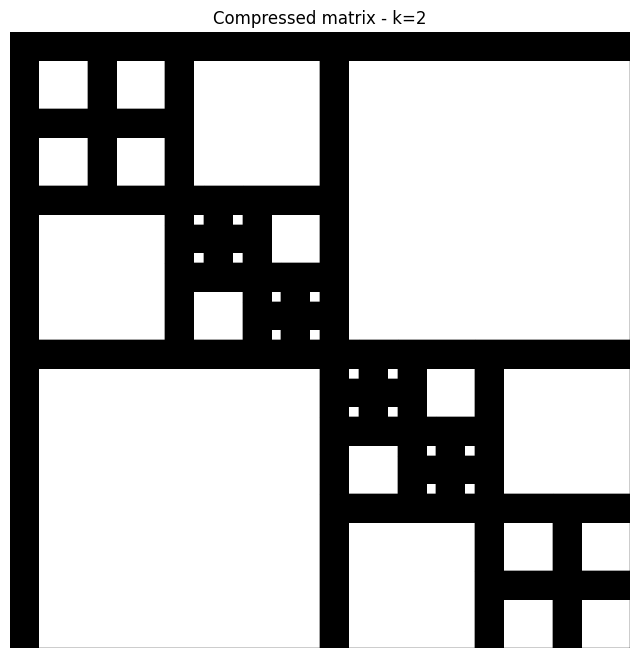

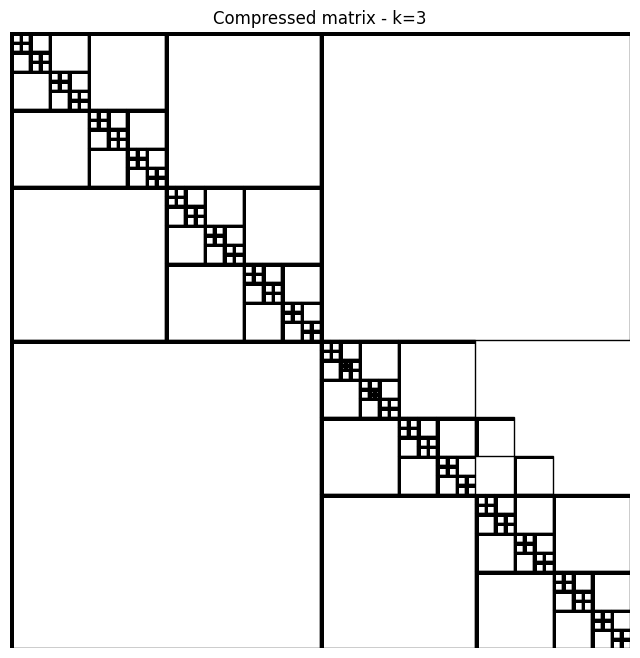

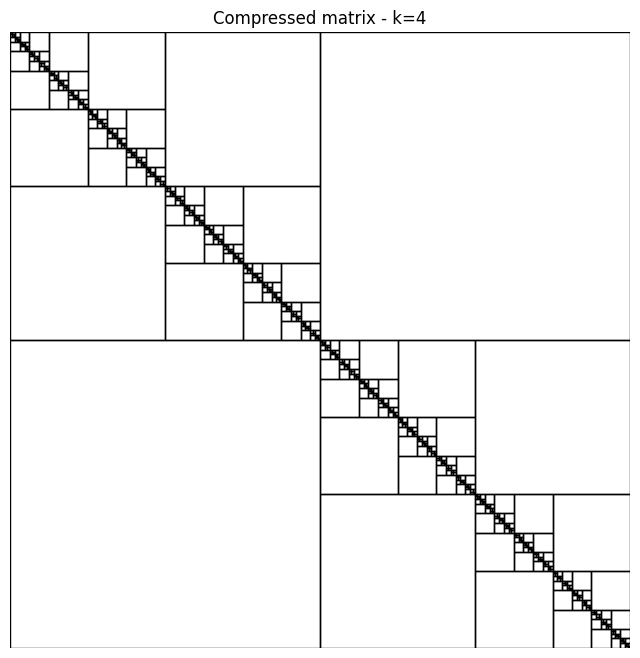

In [8]:
for k in data.keys():
    draw_compressed_matrix(data[k]["compressed"], f"Compressed matrix - k={k}", data[k]["shape"])

## Mnożenie

In [9]:
for k in data.keys():
    matrix = data[k]["compressed"]
    vector = data[k]["vector"]
    
    t0 = time()
    matmul_result = multiply_matrices(matrix, matrix)
    t1 = time()
    vecmul_result = multiply_by_vector(matrix, vector)
    t2 = time()
    
    matmul_time = (t1 - t0) * 1000
    vecmul_time = (t2 - t1) * 1000
    data[k]["matmul_time"] = matmul_time
    data[k]["vecmul_time"] = vecmul_time

    print(f"k={k}:")
    print(f"Matrix multiplication time: {matmul_time}")
    print(f"By vector multiplication time: {vecmul_time}")
    print()

k=2:
Matrix multiplication time: 1.8990039825439453
By vector multiplication time: 0.06890296936035156

k=3:
Matrix multiplication time: 45.295000076293945
By vector multiplication time: 0.34356117248535156

k=4:
Matrix multiplication time: 2518.397331237793
By vector multiplication time: 2.6726722717285156



## Wykres czasu od rozmiaru wraz z dopasowaniem

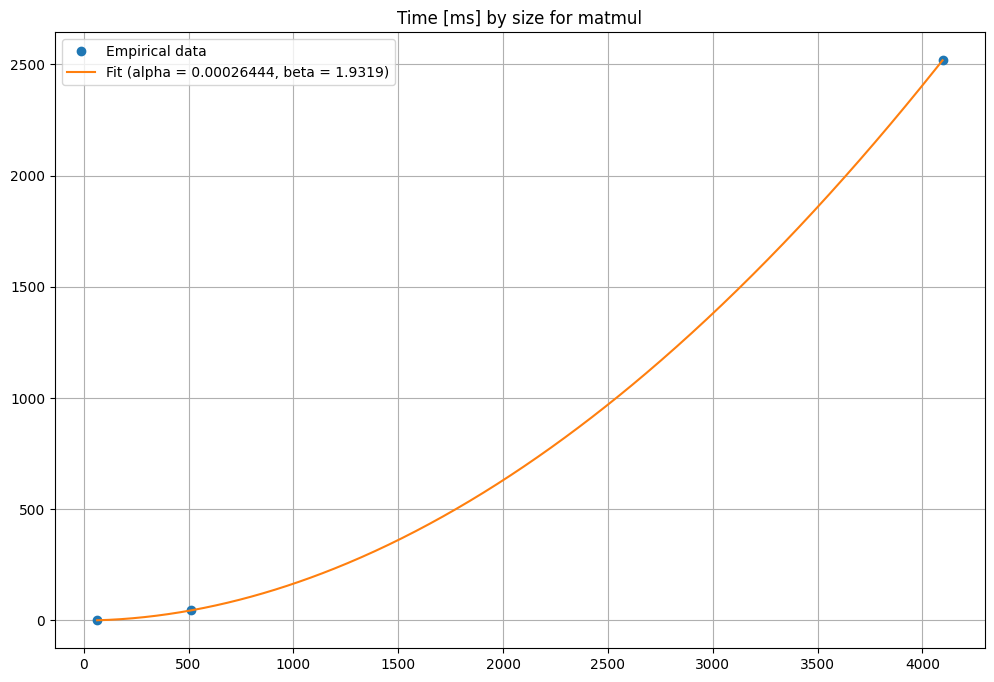

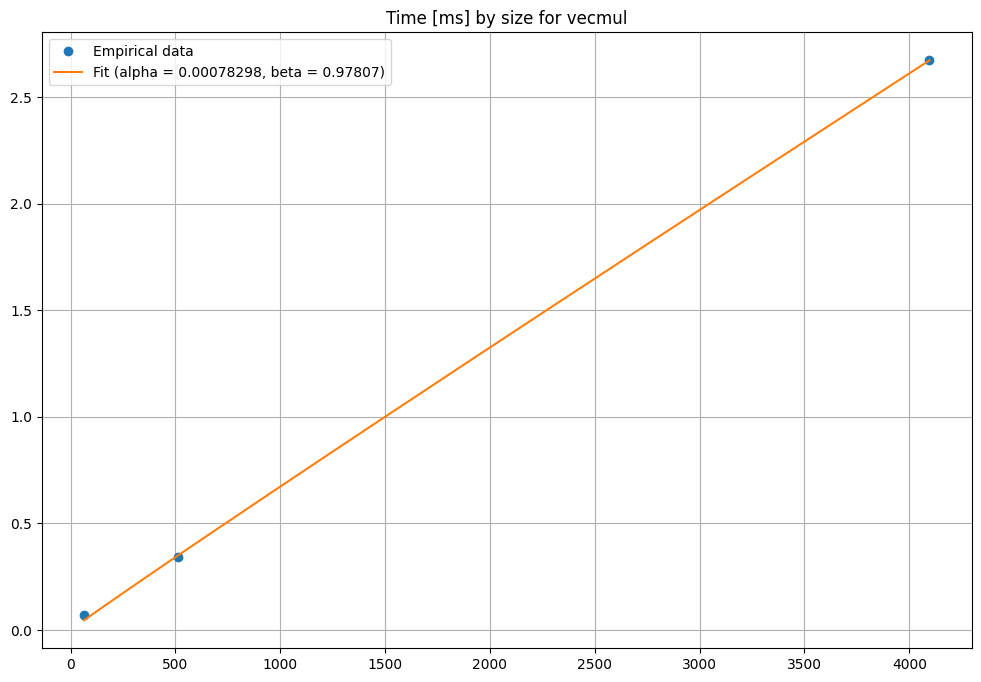

In [10]:
draw_time_plot(data, "matmul")
draw_time_plot(data, "vecmul")

## Norma Frobeniusa

In [11]:
for k in data.keys():
    print(f"k = {k}:")
    matrix = data[k]["matrix"]
    decompressed = get_compressed_matrix(data[k]["compressed"], data[k]["shape"])
    vector = data[k]["vector"]
    data[k]["matmul_frobenius"] = np.sum((matrix@matrix - decompressed@decompressed)**2)
    data[k]["vecmul_frobenius"] = np.sum((matrix@vector - decompressed@vector)**2)
    for mul in ["matmul", "vecmul"]:
        print(f"\t{mul}: {data[k][f"{mul}_frobenius"]:.5}")

k = 2:
	matmul: 74.666
	vecmul: 6.2352
k = 3:
	matmul: 1803.6
	vecmul: 288.7
k = 4:
	matmul: 2.0769e+04
	vecmul: 3924.9
